In [423]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from load_vector_non_smooth import elemental_load_vector_non_smooth_solution
from stiffness_matrix import stiffness_matrix
from load_vector import load_vector
from scipy.interpolate import interp1d
from scipy.integrate import quadrature
matplotlib.rcParams.update({'font.size': 7})

import warnings
warnings.filterwarnings("ignore")

### Utilities

In [424]:
def L2_error(X, u_num, u_exact):
    u_interp = interp1d(X, [0] + list(u_num) + [0], assume_sorted=True)  # Linear interpolation
    return quadrature(lambda x: (u_interp(x) - u_exact(x))**2, 0, 1, maxiter=1000)[0]


def sobolev_error(u_num, u_exact, u_x_exact, X, H):
    L2 = L2_error(X, u_num, u_exact)**2
    u_num = [0] + list(u_num) + [0]
    u_x_interp = interp1d(X, list(np.diff(u_num)/H) + [0], kind="zero", assume_sorted=True)  # Constant interpolation
    H1 = quadrature(lambda x: (u_x_interp(x) - u_x_exact(x))**2, 0, 1, maxiter=1000)[0]
    return np.sqrt(H1 + L2)




def loglog_error(f, u, u_x=None):
    '''
    for calculating the error of FEM. returns array of errors e for different h found in the returned array H.
    - f: r.h.s function for the given solution u
    - u: solution to problem
    - u_x: derivative of u. Implies H1-norm. Use L2-norm if None
    '''
    iterations = 50
    M = np.logspace(1,3,iterations, dtype=int)
    H = 1/M
    e = np.zeros_like(H)
    for i in range(iterations):
        X = np.linspace(0, 1, M[i])
        h = 1/M[i]
        A = stiffness_matrix(alpha=1, b=1, c=2, H=np.full_like(X, h), M=len(X))
        if f != u:
            F = load_vector(f, X, M[i])
        else:
            F = load_vector(f, X, M[i], elemental_load_vector=elemental_load_vector_non_smooth_solution(alpha, b, c))
        u_num = np.linalg.solve(A, F)

        if u_x is None:
            print("l2")
            e[i] = L2_error(X, u_num, u)
        else:
            print("sob")
            e[i] = sobolev_error(u_num, u, u_x, X, np.diff(X))

    return e, H


def loglogplot_error(h, e, ax=None):
    ''' 
    plotting function. uses logarithmic ploting scale
    - h: array of h-values
    - e: array with error values
    - ax: potential given plt object'''

    if ax is None:
        fig, ax = plt.subplots()

    p = np.polyfit(np.log(h), np.log(e), 1)[0]

    ax.set_title("Error")
    ax.loglog(h, e, label=f"p={p:.3f}")
    ax.set_xlabel("h")
    ax.set_ylabel("e")
    #ax.invert_xaxis()
    ax.legend()


def loglog_mainplot(solution_data, error_data, just_inf_norm=False):
    '''
    - solution_data: a 3d array with data assigned to respective ax alon first dim, data assign to num or anal along second dim
      and x and y along third dim
    - error_data: 2d arr with data assigned to respective ax along first dim, x and y values along second dim.
    '''
    fig, ax = plt.subplots(len(solution_data), 1 + int(len(error_data)/2))
    fig.set_figwidth(12)
    fig.set_figheight(4)
    # first solution plot
    ax[0].plot(solution_data[0,0], solution_data[0,1], label='analytical')
    ax[0].plot(solution_data[1,0], solution_data[1,1], label='numerical', linestyle='dashed')
    plt.legend()

    # second solution plot
    ax[1 + int(len(error_data)/2)].plot(solution_data[2,0], solution_data[2,1], label='analytical')
    ax[1 + int(len(error_data)/2)].plot(solution_data[3,0], solution_data[3,1], label='numerical', linestyle='dashed')
    plt.legend()

    # if we are just interested in plotting the error with the use of infinity norm
    if just_inf_norm:
        loglogplot_error(error_data[0,0], error_data[0,1], ax[1])
        loglogplot_error(error_data[0,0], error_data[0,1], ax[3])

    # if we want to plot more types of error-calculations
    else:
        loglogplot_error(error_data[0,0], error_data[0,1], ax[1])
        loglogplot_error(error_data[1,0], error_data[1,1], ax[2])
        loglogplot_error(error_data[2,0], error_data[2,1], ax[4])
        loglogplot_error(error_data[3,0], error_data[3,1], ax[5])

a = np.array([1,2,3,4,5,6])
print(len(a)%2==0)
b = np.delete(a, 0)
print(b)
print(5%2)

True
[2 3 4 5 6]
1


# Example using a solution with constant rhs

Let $c_1=-\frac{e^2 + e}{e^2 + e + 1}$, $c_1=-\frac{1}{e^2 + e + 1}$, and
$$
u(x)=c_1e^{-x} + c_2 e^{2x} + 1
$$
Then, using $\alpha=1$, $b=1$ and $c=2$, we have
$$
f(x)=-(Lu)(x) = 2
$$
This results in the elemental load vector
$$
\vec{F}^{K_i} = h_i (1, 1)^T
$$

In [425]:
M = 100
X = np.sort(np.random.random(M))
X[[0, -1]] = [0, 1]
H = np.diff(X)

alpha = 1
b=1
c=2

def f(x):
    return 2

A = stiffness_matrix(alpha, b, c, H=H, M=M)
F = load_vector(f, X, M)

In [426]:
U = np.linalg.solve(A, F)

In [427]:
def u(x):
    return (-np.exp(2*x)) / (np.exp(1) + np.exp(2) + 1) + np.exp(-x) * (-np.exp(1)- np.exp(2)) / (np.exp(1) + np.exp(2) + 1) + 1

### Stiffness matrix and test example for task 2a):

[[ 953.72461777 -714.79971487    0.         ...    0.
     0.            0.        ]
 [-715.79971487  764.38759903  -48.56610831 ...    0.
     0.            0.        ]
 [   0.          -49.56610831  203.62474797 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...  176.6129493
   -90.46741479    0.        ]
 [   0.            0.            0.         ...  -91.46741479
   362.75765777 -271.27557099]
 [   0.            0.            0.         ...    0.
  -272.27557099  306.14732113]]


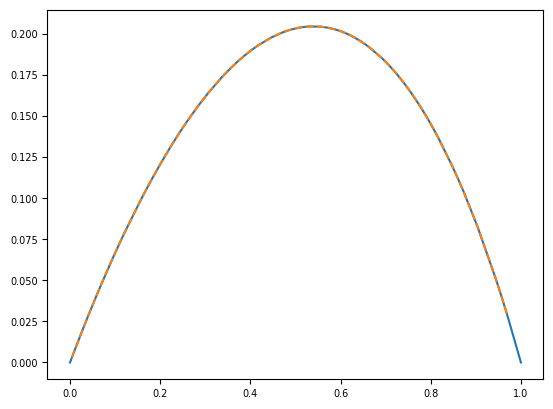

In [428]:
plt.plot(X, u(X))
plt.plot(X[1:-1], U, linestyle='dashed')
print(A)

## 2b

We have two possible test solutions 
$$u_1(x) = x(1-x)$$
and
$$u_2(x) = sin(3 \pi x)$$
This gives the right hand sides 
$$f_1(x) = cx^2 + (c-2b)x + (b-2\alpha)$$
and 
$$f_2(x) = (9\pi^2\alpha+c)sin(3\pi x) + 3\pi b cos(3\pi x)$$
respectively. 

we implement the r.h.s:

In [429]:
def u2b_1(x):
    return x*(1-x)

def u_x_2b_1(x):
    return 1-2*x

def f2b_1(x, alpha=1, b=1, c=2):
    return -c*x**2 + (c-2*b)*x + (b+2*alpha)

def u2b_2(x):
    return np.sin(3*np.pi*x)

def u_x_2b_2(x):
    return 3*np.pi*np.cos(3*np.pi*x)

def f2b_2(x, alpha=1, b=1, c=2):
    return (9*np.pi**2 * alpha + c)*np.sin(3*np.pi*x) + 3*np.pi*b*np.cos(3*np.pi*x)

We then find the load vector and test the method:

l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob


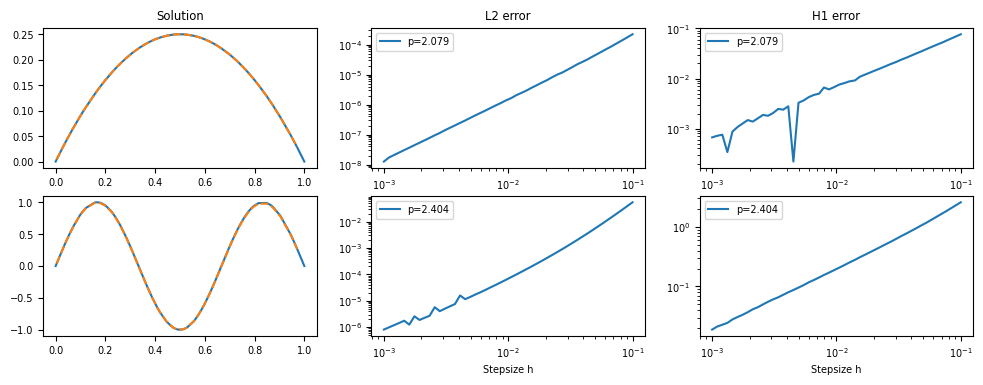

In [430]:
# here we construct the load-vector
F_2b1 = load_vector(f2b_1, X, M)
F_2b2 = load_vector(f2b_2, X, M)

# here we calculate the numerical solution
U_2b1 = np.linalg.solve(A, F_2b1)
U_2b2 = np.linalg.solve(A, F_2b2)

# now we also find the error
e1, H1 = loglog_error(f2b_1, u2b_1)#, u_x_2b_1)
e2, H2 = loglog_error(f2b_2, u2b_2)#, u_x_2b_2)
sob_e1, H1_ = loglog_error(f2b_1, u2b_1, lambda x: 1-2*x)#, u_x_2b_1)
sob_e2, H2_ = loglog_error(f2b_2, u2b_2, lambda x: 3*np.pi*np.cos(3*np.pi*x))#, u_x_2b_2)

p1 = np.polyfit(np.log(H1), np.log(e1), 1)[0]
p2 = np.polyfit(np.log(H2), np.log(e2), 1)[0]
sob_p1 = np.polyfit(np.log(H1), np.log(e1), 1)[0]
sob_p2 = np.polyfit(np.log(H2), np.log(e2), 1)[0]

# Here we plit the figures
plt.figure(figsize=(12,4))

plt.subplot(2,3,1, title='Solution')
plt.plot(X, u2b_1(X))
plt.plot(X[1:-1], U_2b1, linestyle='dashed')

plt.subplot(2,3,4)
plt.plot(X, u2b_2(X))
plt.plot(X[1:-1], U_2b2, linestyle='dashed')

plt.subplot(2,3,2, title='L2 error')
plt.loglog(H1, e1, label=f"p={p1:.3f}")
plt.xlabel('Stepsize h')
#plt.ylabel('error')
plt.legend()

plt.subplot(2,3,5)
plt.loglog(H2, e2, label=f"p={p2:.3f}")
plt.xlabel('Stepsize h')
#plt.ylabel('error')
plt.legend()

plt.subplot(2,3,3, title='H1 error')
plt.loglog(H1, sob_e1, label=f"p={sob_p1:.3f}")
plt.xlabel('Stepsize h')
#plt.ylabel('error')
plt.legend()

plt.subplot(2,3,6)
plt.loglog(H2, sob_e2, label=f"p={sob_p2:.3f}")
plt.xlabel('Stepsize h')
#plt.ylabel('error')
plt.legend()

### 2d

$$
w_1(x) = \begin{cases}
2x &, \quad x \in \left(0, \frac{1}{2}\right) \\
2-2x &, \quad x \in \left(\frac{1}{2}, 1\right)
\end{cases}
$$

In [431]:
'''IMPLEMENTATION'''

def w1(x):
    return (x < 0.5) * 2*x + (x >= 0.5) * (2-2*x)
def w1_x(x):
    return 2*np.sign(0.5-x)

def w2(x):
    return x - np.power(x, 2/3)
def w2_x(x):
    return 1 - 2/3 * np.power(x, -1/3)


In [432]:
'''INITIALIZATION'''

# alpha = 2
# b = 1
# c = 1

M = 300
X = np.sort(np.random.random(M))
X[[0, -1]] = [0, 1]
H = np.diff(X)

# calculating numerical and analytical values of w1 and w2 based on X
A = stiffness_matrix(alpha, b, c, H, M)
F_w1 = load_vector(w1, X, M, elemental_load_vector_non_smooth_solution(alpha, b, c))
U_w1 = np.linalg.solve(A, F_w1)
F_w2 = load_vector(w2, X, M, elemental_load_vector_non_smooth_solution(alpha, b, c))
U_w2 = np.linalg.solve(A, F_w2)

# claculating error 
e_w1_L2, H_w1_L2 = loglog_error(w1, w1)
e_w1_H1, H_w1_H1 = loglog_error(w1, w1, w1_x)

e_w2_L2, H_w2_L2 = loglog_error(w2, w2)
e_w2_H1, H_w2_H1 = loglog_error(w2, w2, w2_x)



l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
l2
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob
sob


### Solution with error in $L^2$ and $H^1$

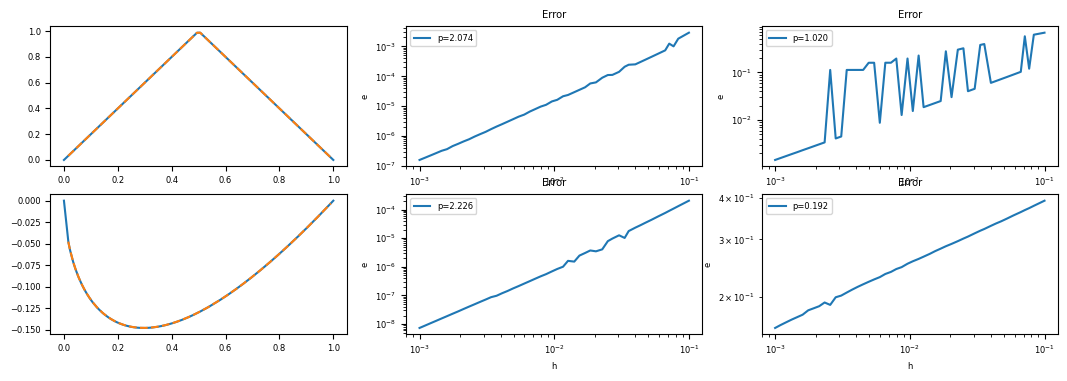

In [433]:

matplotlib.rcParams.update({'font.size': 6})
'''PLOTTING'''
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
fig.set_figwidth(13)
fig.set_figheight(4)
# plotting w1
ax1.plot(X, w1(X), label='analytical')
ax1.plot(X[1:-1], U_w1, label='numerical', linestyle='dashed')
# plotting error for w1 
loglogplot_error(H_w1_L2, e_w1_L2, ax2)
loglogplot_error(H_w1_H1, e_w1_H1, ax3)
# plottting w2
ax4.plot(X, w2(X), label='analytical')
ax4.plot(X[1:-1], U_w2, label='numerical', linestyle='dashed')
# plotting error for w1 
loglogplot_error(H_w2_L2, e_w2_L2, ax5)
loglogplot_error(H_w2_H1, e_w2_H1, ax6)

## 2e

In [434]:
def u2e(x):
    return 1/(x**(1/4))

# def f_2e(x, alpha=2, b=1, c=1):
#     return -alpha*5/(16*x**(9/4)) - b/(4*x**(5/4)) + c*(1/x**(1/4))

def nonuniform_nodes(start, end, num_nodes):
    t = np.linspace(0, 1, num_nodes)
    f = lambda x: start + (end - start) * x ** 2
    nodes = f(t)
    return nodes

def L2_error_(X_num, X_exact, u_num, u_exact):
    u_interp_num = interp1d(X_num, [0] + list(u_num) + [0], assume_sorted=True)  # Linear interpolation
    u_interp_exact = interp1d(X_exact, [0] + list(u_exact) + [0], assume_sorted=True) 
    return quadrature(lambda x: (u_interp_num(x) - u_interp_exact(x))**2, 0, 1, maxiter=1000)[0]


 error between log and high-res: 1.59165760860556e-14
error between equidistant nodes and high-res: 2.6770977570211136e-11
1681.9558066678046


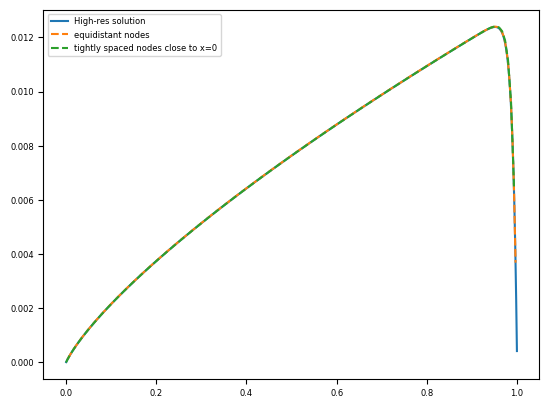

In [435]:
M = 300
alpha = 1
b = 100
c = 1

# with equidistant nodes
X = np.linspace(0, 1, M)
H = np.diff(X)
A = stiffness_matrix(alpha, b, c, H, M)
F = load_vector(u2e, X, M)
U = np.linalg.solve(A, F)

# with more nodes close to x=0
log_X = np.flip(1/np.logspace(0, 2, M))
log_X = nonuniform_nodes(0,1,M)
log_H = np.diff(log_X)
log_A = stiffness_matrix(alpha, b, c, log_H, M)
log_F = load_vector(u2e, log_X, M)
log_U = np.linalg.solve(log_A, log_F)

# high resolution solution
hrM = 3000
hrX = np.linspace(0, 1, hrM)
hrH = np.diff(hrX)
hrA = stiffness_matrix(alpha, b, c, hrH, hrM)
hrF = load_vector(u2e, hrX, hrM)
hrU = np.linalg.solve(hrA, hrF)

# finding error between high res and the thwo others
hr_log_error_U = L2_error_(log_X, hrX, log_U, hrU)
print(f' error between log and high-res: {hr_log_error_U}')
hr__error_U = L2_error_(X, hrX, U, hrU)
print(f'error between equidistant nodes and high-res: {hr__error_U}')
print(hr__error_U/hr_log_error_U)

# plotting 
plt.figure()
plt.plot(hrX[1:-1], hrU, label='High-res solution')
plt.plot(X[1:-1], U, label='equidistant nodes', linestyle='dashed')
plt.plot(log_X[1:-1], log_U, label='tightly spaced nodes close to x=0', linestyle='dashed')
plt.legend()